# Deep Q-Learning

We'll start first by explaining two elements of Markov Decision Process (MDP): policy $\pi$ and its state-action functions $Q_\pi$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook
from grid import GRID, ACTIONS_NAMES
from IPython.display import HTML
from base64 import b64encode

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100


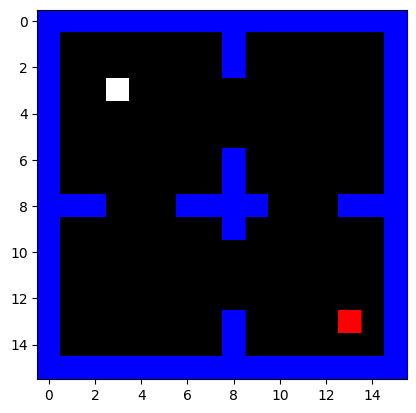

In [2]:
environment = GRID(grid_size=16, max_time=2000)
environment.reset()
environment.render()


We'll be using a _4-rooms_ environment where the goal of the agent (white square) is to reach the target (red square).
The grid is 16 by 16, so there are 256 states. Not all the states are accessible, since the agent can't cross the blue walls.
Each state $s$ is represented as a tuple $(x_s, y_s)$ that reflects the position of the agent.

There are 4 possible actions at each state (clockwise): Up (0), Right(1), Down(2), Left(3).
The agent gets a penalty (reward = -1) if it hits the blue walls and a reward = 1 if it reaches the target.
The episode ends (game over) when the target is reached or the agent has taken 2000 steps.

We will be using Q-learning to find a good policy that will allow us to reach the target before the time runs out.

At step $t$, the agent is located at state $s_t$ and chooses an action $a_t = \pi(s_t)$ following the policy $\pi$

The agent then gets reward $r_t$ and moves to state $s_{t+1}$. The process repeats until we reach a final state $s_T$ (`game_over == True`)

We'll call a replay a sequence of tuples $(s_t, a_t, r_t, s_{t+1})$.

Initial state:(3, 3)
Took action: Down
New state: (4, 3)
Reward: 0
Game over:False


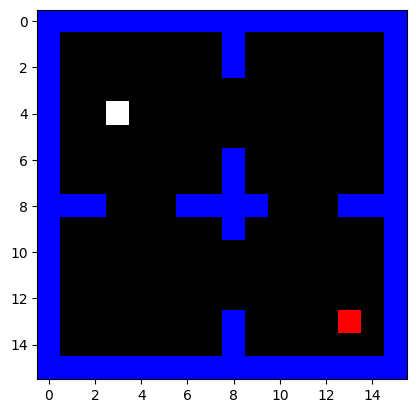

In [3]:
# How to create a replay with one element
# repeat as long as game_over is false
replay = []
current_state = environment.reset()
action = 2
print("Initial state:{}".format(current_state))
new_state, reward, game_over = environment.step(action)  # down
replay.append((current_state, action, reward, new_state))
current_state = new_state
print("Took action: {}".format(ACTIONS_NAMES[action]))
print("New state: {}\nReward: {}\nGame over:{}".format(new_state, reward, game_over))
environment.render()

Starting at time $t=0$, The agent's goal is to maximize the expected discounted rewards:
\begin{align}
\eta_\pi = \sum_{t | a_t =\pi(s_t)} \gamma^t r_t
\end{align}
$0<\gamma<1$ is the discount rate. We'll be using $\gamma = 0.95$

The main role of discounting the rewards is to motivate the agent to achieve the goal as early as possible (no procrastination).

It makes reaching the goal at $t=1$, for example, more desirable than at $t=100$: $r_1=1$ contributes $\gamma^1 =0.95$ while $r_{100} = 1$ will only count as $\gamma^{100} =0.006$ in $\eta_\pi$.

$Q_\pi(s_t, a_t)$ is defined as the expected discounted rewards if we start at state $s_t$, take an initial actions $a_t$, and
follow the policy $\pi$ to decide the remaining action $(a_{t+1},..... a_{T-1})$.

\begin{align}
Q_\pi(s,a) = \eta_\pi, \text{ such that } s_0 = s \text{ and } a_0 = a
\end{align}

The principle behind Q-learning, as the name suggests, is to learn the optimal $Q^*$.
Since at each instant $t$, we want to pick the action that yields the best expected rewards, the optimal policy $\pi^*$ would be:
\begin{align}
\pi^*(s) = \arg\max_a Q^*(s, a)
\end{align}

__So how do we learn the optimal $Q^*$?__

By exploring the environment and saving a replay $\text{Replay} = \{(s_t, a_t, r_t, s_{t+1})| t\leq T\}$ (one that reaches the goal, hopefully),

we can use _Bellman equations_ to update our estimate of the $Q$ function in the following way:
\begin{align}
Q_{new}(s_t, a_t) \leftarrow r_t + \gamma \max_a Q_{old}(s_{t+1}, a), \;\;\; \forall \; (s_t, a_t, r_t, s_{t+1})\in \text{Replay}
\end{align}

We can prove that repeating this update will make our estimate converge to a unique optimal state-action value function $Q^*$.

Instead of "brutally" updating Q, we'll use a learning rate $\alpha$, so that the update would be :
\begin{align}
Q_{new}(s_t, a_t) \leftarrow  (1-\alpha)Q_{old}(s_t, a_t) + \alpha\big[r_t + \gamma \max_a Q_{old}(s_{t+1}, a) \big]
\end{align}

In this first part, we'll use an array `Q` of shape (16 x 16 x 4) to store $Q$, and the value $Q(s,a)$ would be accessed via `Q[x_s, y_s, a]`.

- **[Q]** Complete the class method `TabularQ.update` to apply _Bellman_ updates provided a replay

In [4]:
class TabularQ:
    def __init__(self, gamma=0.95, learning_rate=0.01):
        self.Q = np.zeros((16, 16, 4))
        self.gamma = gamma
        self.alpha = learning_rate

    def update(self, replay):
        for s_t, a_t, r_t, s_t_p_1 in replay:
            # Workspace 4.1
            #BEGIN
            s_x, s_y = s_t
            s_p_x, s_p_y = s_t_p_1
            self.Q[s_x, s_y, a_t] *= (1 - self.alpha)
            self.Q[s_x, s_y, a_t] += self.alpha * (r_t + self.gamma * np.max(self.Q[s_p_x, s_p_y]))
            #END

    def best_action(self, s):
        action = np.argmax(self.Q[s[0], s[1]])
        return action

    def save(self, checkpoint_name):
        np.savez_compressed(checkpoint_name, Q=self.Q)

    def load(self, checkpoint_name):
        self.Q = np.load(checkpoint_name +".npz" )["Q"]

class Policy():

    def __init__(self, Q, epsilon=1):
        self.Q = Q
        self.epsilon = epsilon

    def act(self, state):
        if np.random.uniform(0, 1) <= self.epsilon:
            return np.random.choice([0, 1, 2, 3])
        else:
            return self.Q.best_action(state)

Now we have to address a different question: when we explore the environment, how should we choose the actions?

One approach is to follow a $\epsilon$-greedy policy, where we choose a random action with probability $\epsilon$ and the best action according to Q with probability $1-\epsilon$.

For instance, if $\epsilon=1$, all actions are chosen randomly. For $\epsilon=0$, all actions are chosen _greedily_.
A common practice is to start with $\epsilon=1$ and decay it to 0 as we generate replays. How fast we decay it is related to the famous _exploration-exploitation_ dilemma in Reinforcement Learning.

**[Q]** Complete the cell below to generate replays and update `tabular_Q` for `n_episodes`. You're free to choose your own decaying rate for $epsilon$ (including a 0 decay)


In [5]:
tabular_Q = TabularQ()
n_episodes = 20
greedy_policy = Policy(tabular_Q, epsilon=1.0)
decay = 0.995
def play(environment, policy):
    # Returns one episode's replay and the total accumulated rewards
    replay = []
    current_state = environment.reset()
    game_over = False
    total_rewards = 0
    while not game_over:
        action = policy.act(current_state)
        new_state, reward, game_over = environment.step(action)
        replay.append((current_state, action, reward, new_state))
        current_state = new_state
        total_rewards += reward
    return replay, total_rewards

for _ in range(n_episodes):
    # Workspace 4.2
    #BEGIN
    tabular_Q.update(play(environment, greedy_policy)[0])
    greedy_policy.epsilon *= decay
    #END

In [6]:

def save_frames(frames, target_mp4):
    import imageio
    imageio.mimwrite('{}.mp4'.format(target_mp4), np.array(frames, dtype="uint8"), fps=30)


def evaluate_policy(policy, target_mp4, random=False, n_episodes=10):
    env = GRID(random=False, max_time=100)
    frames = []
    for _ in tqdm.notebook.tqdm(range(n_episodes)):
        state = env.reset()
        game_over = False
        while not game_over:
            action = policy.act(state)
            state, _, game_over = env.step(policy.act(state))
        frames += env.episode
    save_frames(frames, "multi_episodes")


def display_video(target_mp4):
    mp4 = open('{}.mp4'.format(target_mp4), 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
        <video width=320 controls>
            <source src="%s" type="video/mp4">
        </video>
        """ % data_url)

Now let's examine how the agent behaves a following random policy vs our Q-learning policy.

You should notice that if you run Q-learning multiple times, you might get different policies (different ways to reach the target) : we've mentioned before that $Q^*$ is unique, it's not the case for $\pi^*$

In [7]:
_ = play(environment, Policy(tabular_Q, epsilon=1.0)) # completely random policy
save_frames(environment.episode, target_mp4="uniform") # saves the episode to uniform.mp4
display_video("uniform") # display uniform.mp4

In [8]:
_ = play(environment, Policy(tabular_Q, epsilon=0.0)) # optimal policy
save_frames(environment.episode, target_mp4="best_tabular")
display_video("best_tabular") # display uniform.mp4

- 4.3 **[1 point]** To get the full credit of the previous questions, you'll have to submit a zip file `q_learning.zip` that includes `uniform.mp4`, `best_tabular.mp4` from previous cells and `best_tabular.npz` from the cell below

_Hint_:  If cells ran correctly, the files should appear in the same path as the notebook

In [9]:
tabular_Q.save("best_tabular")